# Imports & file locations

In [5]:
%load_ext autoreload
%autoreload 2

import glob
import itertools
import os

import numpy as np
import scanpy 
import scanpy as sc
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
from sklearn.metrics import normalized_mutual_info_score

import anndata

# Joblib for parallelizing
from joblib import Parallel, delayed 

pd.options.display.max_columns = 100
pd.options.display.max_rows = 100


anndata.__version__

scanpy.settings.verbosity = 3
#sc.set_figure_params(dpi=200, dpi_save=300)
scanpy.logging.print_versions()
scanpy.set_figure_params(frameon=False, color_map='magma_r')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
scanpy==1.4.6.dev9+ge632939 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.3 scipy==1.3.2 pandas==0.25.3 scikit-learn==0.22 statsmodels==0.10.2 python-igraph==0.7.1 louvain==0.6.1


In [6]:
outdir_gdrive = '/home/olga/googledrive/TabulaMicrocebus/data/cross-species'
outdir_local = '/home/olga/data_lg/data_sm_copy/tabula-microcebus/data-objects/cross-species'
outdirs = outdir_local, outdir_gdrive
!ls -lha $outdir_local

total 35G
drwxrwxr-x 14 olga czb  8.0K May 26 08:39 .
drwxrwxr-x  7 olga czb  4.0K May  7 15:55 ..
drwxrwxr-x  3 olga czb  4.0K Mar 21 21:55 alltissues__10x__lemur__one2one_orthologs__csvs
-rw-rw-r--  1 olga czb  2.1G May 18 15:07 alltissues__10x__lemur__one2one_orthologs.h5ad
drwxrwxr-x  3 olga czb  4.0K Mar 21 16:49 alltissues__10x__mouse__one2one_orthologs__csvs
-rw-rw-r--  1 olga czb  3.1G May 18 15:04 alltissues__10x__mouse__one2one_orthologs.h5ad
drwxr-xr-x  3 olga czb   16K Jun  5 14:49 binarized
-rw-r--r--  1 olga czb   21K May 19 08:02 binarized_expression__stable_genes__compartment_primate_enriched.csv
-rw-r--r--  1 olga czb  1.1M May 19 07:19 binarized_gene_expression__stable_genes_by_mutual_information__fraction_per_compartment.csv
-rw-r--r--  1 olga czb  2.8M May 19 07:19 binarized_gene_expression__stable_genes_by_mutual_information__go_enrichment.csv
-rw-r--r--  1 olga czb   25K May 19 07:19 binarized_gene_expression__stable_genes_by_mutual_information.txt
-rw-r--r--  1 o

# Load data

In [7]:
%%time
h5ad = f'{outdir_local}/concatenated__human-lung--lemur-lung--mouse-lung__10x__one2one_orthologs__unified_compartments__bbknn.h5ad'
adata = scanpy.read_h5ad(h5ad)
adata

CPU times: user 416 ms, sys: 656 ms, total: 1.07 s
Wall time: 6.7 s


AnnData object with n_obs × n_vars = 52815 × 11761 
    obs: 'age', 'batch', 'cell', 'cell_barcode', 'cell_ontology_class', 'cell_ontology_id', 'channel', 'channel_no_10x', 'channel_tissue', 'compartment', 'compartment_id', 'free_annotation', 'individual', 'location', 'magnetic.selection', 'method', 'mouse.id', 'nGene', 'nUMI', 'n_barcodes', 'n_counts', 'n_genes', 'orig.ident', 'original_channel', 'patient', 'percent.ribo', 'possibly_contaminated_barcode', 'preparation.site', 'region', 'sample', 'sequencing_run', 'sex', 'species', 'species_batch', 'species_latin', 'subtissue', 'tissue', 'tissue_free_annotation', 'compartment_updated_from_human', 'compartment_updated_from_human__with_species', 'compartment_updated_from_lemur', 'compartment_updated_from_lemur__with_species', 'narrow_group', 'broad_group', 'compartment_group', 'log_counts', 'sqrt_counts'
    var: 'mouse_lemur__gene_name', 'mouse_lemur_to_human__homology_type', 'human_to_mouse__homology_type', 'mouse__gene_name', 'gene_ids

In [8]:
adata.obs = adata.obs.replace('nan', np.nan)

In [9]:
adata.obs['cell_barcode'].isnull().sum()

0

## only use narrow groups that are shared across all

In [10]:
adata_same_narrow_group = adata[adata.obs.groupby('narrow_group').filter(lambda x: x.species.nunique() == 3).index]
adata_same_narrow_group

View of AnnData object with n_obs × n_vars = 43114 × 11761 
    obs: 'age', 'batch', 'cell', 'cell_barcode', 'cell_ontology_class', 'cell_ontology_id', 'channel', 'channel_no_10x', 'channel_tissue', 'compartment', 'compartment_id', 'free_annotation', 'individual', 'location', 'magnetic.selection', 'method', 'mouse.id', 'nGene', 'nUMI', 'n_barcodes', 'n_counts', 'n_genes', 'orig.ident', 'original_channel', 'patient', 'percent.ribo', 'possibly_contaminated_barcode', 'preparation.site', 'region', 'sample', 'sequencing_run', 'sex', 'species', 'species_batch', 'species_latin', 'subtissue', 'tissue', 'tissue_free_annotation', 'compartment_updated_from_human', 'compartment_updated_from_human__with_species', 'compartment_updated_from_lemur', 'compartment_updated_from_lemur__with_species', 'narrow_group', 'broad_group', 'compartment_group', 'log_counts', 'sqrt_counts'
    var: 'mouse_lemur__gene_name', 'mouse_lemur_to_human__homology_type', 'human_to_mouse__homology_type', 'mouse__gene_name', '

In [11]:
sorted(adata_same_narrow_group.obs.narrow_group.unique())

['Adventitial Fibroblast',
 'Airway Smooth Muscle and Myofibroblast',
 'Alveolar Epithelial Type 2',
 'Alveolar Fibroblast',
 'B cell',
 'CD4+ T',
 'CD8+ T',
 'Capillary',
 'Capillary Aerocyte',
 'Ciliated',
 'Lymphatic',
 'Macrophage',
 'Monocyte',
 'Myeloid Dendritic',
 'Natural Killer',
 'Natural Killer T cell',
 'Pericyte',
 'Plasma',
 'Plasmacytoid Dendritic',
 'Proliferating Macrophage',
 'Proliferating NK/T',
 'Vein']

## Lets use alveolar epithellial type 2 and macrophages because those seem to have strong primate signal

In [12]:
at2_macrophages = ['Alveolar Epithelial Type 2',  'Macrophage',]

adata_at2_macrophages = adata_same_narrow_group[adata_same_narrow_group.obs.narrow_group.isin(at2_macrophages)]
adata_at2_macrophages

View of AnnData object with n_obs × n_vars = 22986 × 11761 
    obs: 'age', 'batch', 'cell', 'cell_barcode', 'cell_ontology_class', 'cell_ontology_id', 'channel', 'channel_no_10x', 'channel_tissue', 'compartment', 'compartment_id', 'free_annotation', 'individual', 'location', 'magnetic.selection', 'method', 'mouse.id', 'nGene', 'nUMI', 'n_barcodes', 'n_counts', 'n_genes', 'orig.ident', 'original_channel', 'patient', 'percent.ribo', 'possibly_contaminated_barcode', 'preparation.site', 'region', 'sample', 'sequencing_run', 'sex', 'species', 'species_batch', 'species_latin', 'subtissue', 'tissue', 'tissue_free_annotation', 'compartment_updated_from_human', 'compartment_updated_from_human__with_species', 'compartment_updated_from_lemur', 'compartment_updated_from_lemur__with_species', 'narrow_group', 'broad_group', 'compartment_group', 'log_counts', 'sqrt_counts'
    var: 'mouse_lemur__gene_name', 'mouse_lemur_to_human__homology_type', 'human_to_mouse__homology_type', 'mouse__gene_name', '

In [13]:
adata_at2_macrophages.obs.groupby(['narrow_group', 'species_batch']).size()

narrow_group                species_batch
Alveolar Epithelial Type 2  human             3427
                            lemur              732
                            mouse              107
Macrophage                  human            12721
                            lemur             5079
                            mouse              920
dtype: int64

In [14]:
adata_at2_macrophages.obs.groupby(['narrow_group', 'channel']).n_genes.describe()

count         mean  \
narrow_group               channel                                       
Alveolar Epithelial Type 2 10X_P1_14                  1.0  1313.000000   
                           10X_P2_5                   3.0  2056.666667   
                           10X_P3_0                   1.0  1792.000000   
                           10X_P5_13                  6.0  1363.500000   
                           10X_P7_8                   1.0  2510.000000   
                           10X_P7_9                   1.0  1779.000000   
                           10X_P8_12                 35.0  1649.142857   
                           10X_P8_13                 13.0  1576.230769   
                           Antoine_Lung_CD31_10X    305.0  1462.400000   
                           Antoine_Lung_EPCAM_10X   182.0  1662.395604   
                           Antoine_Lung_P3_10X       21.0  1626.809524   
                           Bernard_Lung_10X          81.0  2182.728395   
                           MACA_18m_F_LUNG_51         3.0  2024.333333   
                           MACA_18m_M_LUNG_52        17.0  1620.882353   
                           MACA_18m_M_LUNG_53        10.0  1728.600000   
                           MACA_21m_F_LUNG_54         6.0  1701.666667   
                           MACA_21m_F_LUNG_55        10.0  1585.500000   
                           P1_2                     383.0  1693.986945   
                           P1_3                       4.0  1532.250000   
                           P1_4                      50.0  1636.420000   
                           P2_1                      81.0  1695.580247   
                           P2_2                       6.0  1837.166667   
                           P2_3                       2.0  1241.500000   
                           P2_4                      58.0  1848.534483   
                           P2_5                      71.0  1560.436620   
                           P2_6                      63.0  1974.555556   
                           P2_7                      81.0  1787.333333   
                           P2_8                      47.0  1660.021277   
                           P3_2                      16.0  1940.187500   
                           P3_3                    1336.0  1573.105539   
                           P3_4                      26.0  1914.038462   
                           P3_5                      80.0  1540.675000   
                           P3_6                    1118.0  1439.584973   
                           P3_7                       5.0  1919.600000   
                           Stumpy_Lung_10X          143.0  1404.461538   
Macrophage                 10X_P1_6                  15.0  1144.866667   
                           10X_P1_14                 14.0  1191.428571   
                           10X_P2_5                  66.0  1481.742424   
                           10X_P3_0                  20.0  1694.350000   
                           10X_P5_13                 97.0  1256.649485   
                           10X_P5_14                284.0  1314.605634   
                           10X_P7_8                  44.0  1459.636364   
                           10X_P7_9                  66.0  1484.363636   
                           10X_P8_12                  7.0  1547.428571   
                           10X_P8_13                 54.0  1476.407407   
                           Antoine_Lung_CD31_10X   2612.0  1622.598775   
                           Antoine_Lung_EPCAM_10X   523.0  1334.652008   
                           Antoine_Lung_P3_10X       14.0  1624.642857   
                           Bernard_Lung_10X        1000.0  1995.810000   
                           MACA_18m_F_LUNG_50        14.0  1754.142857   
                           MACA_18m_F_LUNG_51        82.0  1488.000000   
                           MACA_18m_M_LUNG_52        42.0  1306.452381   
                           MACA_18m_M_LUNG_53        36.

## Filter for at least 5 cells per channel

In [15]:
adata_at2_macrophages_five_per_channel = adata_at2_macrophages[adata_at2_macrophages.obs.groupby(['narrow_group', 'channel']).filter(lambda x: len(x) >= 5).index]
adata_at2_macrophages_five_per_channel

View of AnnData object with n_obs × n_vars = 22970 × 11761 
    obs: 'age', 'batch', 'cell', 'cell_barcode', 'cell_ontology_class', 'cell_ontology_id', 'channel', 'channel_no_10x', 'channel_tissue', 'compartment', 'compartment_id', 'free_annotation', 'individual', 'location', 'magnetic.selection', 'method', 'mouse.id', 'nGene', 'nUMI', 'n_barcodes', 'n_counts', 'n_genes', 'orig.ident', 'original_channel', 'patient', 'percent.ribo', 'possibly_contaminated_barcode', 'preparation.site', 'region', 'sample', 'sequencing_run', 'sex', 'species', 'species_batch', 'species_latin', 'subtissue', 'tissue', 'tissue_free_annotation', 'compartment_updated_from_human', 'compartment_updated_from_human__with_species', 'compartment_updated_from_lemur', 'compartment_updated_from_lemur__with_species', 'narrow_group', 'broad_group', 'compartment_group', 'log_counts', 'sqrt_counts'
    var: 'mouse_lemur__gene_name', 'mouse_lemur_to_human__homology_type', 'human_to_mouse__homology_type', 'mouse__gene_name', '

In [16]:
adata_at2_macrophages_five_per_channel.obs.groupby(['narrow_group','species_batch', 'channel']).n_genes.describe()

count  \
narrow_group               species_batch channel                          
Alveolar Epithelial Type 2 human         P1_2                     383.0   
                                         P1_4                      50.0   
                                         P2_1                      81.0   
                                         P2_2                       6.0   
                                         P2_4                      58.0   
                                         P2_5                      71.0   
                                         P2_6                      63.0   
                                         P2_7                      81.0   
                                         P2_8                      47.0   
                                         P3_2                      16.0   
                                         P3_3                    1336.0   
                                         P3_4                      26.0   
                                         P3_5                      80.0   
                                         P3_6                    1118.0   
                                         P3_7                       5.0   
                           lemur         Antoine_Lung_CD31_10X    305.0   
                                         Antoine_Lung_EPCAM_10X   182.0   
                                         Antoine_Lung_P3_10X       21.0   
                                         Bernard_Lung_10X          81.0   
                                         Stumpy_Lung_10X          143.0   
                           mouse         10X_P5_13                  6.0   
                                         10X_P8_12                 35.0   
                                         10X_P8_13                 13.0   
                                         MACA_18m_M_LUNG_52        17.0   
                                         MACA_18m_M_LUNG_53        10.0   
                                         MACA_21m_F_LUNG_54         6.0   
                                         MACA_21m_F_LUNG_55        10.0   
Macrophage                 human         P1_2                     836.0   
                                         P1_3                     563.0   
                                         P1_4                    1475.0   
                                         P2_1                     373.0   
                                         P2_2                     358.0   
                                         P2_3                     185.0   
                                         P2_4                     194.0   
                                         P2_5                    2279.0   
                                         P2_6                     202.0   
                                         P2_7                     418.0   
                                         P2_8                    1549.0   
                                         P3_2                      70.0   
                                         P3_3                     390.0   
                                         P3_4                     270.0   
                                         P3_5                    2039.0   
                                         P3_6                    1191.0   
                                         P3_7                     329.0   
                           lemur         Antoine_Lung_CD31_10X   2612.0   
                                         Antoine_Lung_EPCAM_10X   523.0   
                                         Antoine_Lung_P3_10X       14.0   
                                         Bernard_Lung_10X        1000.0   
                                         Martine_Lung_1_10X        53.0   
                                         Martine_Lung_2_10X        52.0   
                                         Stumpy_Lung_10X          825.0   
                           mouse         10X_P1_6                  15.0   
                

In [17]:
adata_at2_macrophages_five_per_channel.obs.query('species_batch == "mouse"')[['age', 'channel']].drop_duplicates()

,age,channel
AAAGCAACATGGTAGG-1-11-0-0-mouse,18m,MACA_18m_F_LUNG_50
AACTCAGAGTGAAGTT-1-12-0-0-mouse,18m,MACA_18m_F_LUNG_51
AACACGTAGGATGGAA-1-31-0-0-mouse,18m,MACA_18m_M_LUNG_52
AAATGCCGTACAAGTA-1-32-0-0-mouse,18m,MACA_18m_M_LUNG_53
AAACCTGGTTGGTGGA-1-52-0-0-mouse,21m,MACA_21m_F_LUNG_54
AACTGGTTCCATGCTC-1-53-0-0-mouse,21m,MACA_21m_F_LUNG_55
AAAGTAGGTCTAAAGA-1-6-1-0-mouse,30m,10X_P1_6
AGCTTGAAGCTAGCCC-1-14-1-0-mouse,30m,10X_P1_14
AAAGATGTCGGACAAG-1-22-1-0-mouse,30m,10X_P2_5
AAAGATGGTCCTCCAT-1-33-1-0-mouse,30m,10X_P3_0


## Pick a subset of channels to use

In [18]:
channels_to_use = ['P1_2', 'Antoine_Lung_EPCAM_10X', 'MACA_21m_F_LUNG_55']

adata_at2_macrophages_channel_subset = adata_at2_macrophages_five_per_channel[adata_at2_macrophages_five_per_channel.obs.channel.isin(channels_to_use)]
adata_at2_macrophages_channel_subset

View of AnnData object with n_obs × n_vars = 1979 × 11761 
    obs: 'age', 'batch', 'cell', 'cell_barcode', 'cell_ontology_class', 'cell_ontology_id', 'channel', 'channel_no_10x', 'channel_tissue', 'compartment', 'compartment_id', 'free_annotation', 'individual', 'location', 'magnetic.selection', 'method', 'mouse.id', 'nGene', 'nUMI', 'n_barcodes', 'n_counts', 'n_genes', 'orig.ident', 'original_channel', 'patient', 'percent.ribo', 'possibly_contaminated_barcode', 'preparation.site', 'region', 'sample', 'sequencing_run', 'sex', 'species', 'species_batch', 'species_latin', 'subtissue', 'tissue', 'tissue_free_annotation', 'compartment_updated_from_human', 'compartment_updated_from_human__with_species', 'compartment_updated_from_lemur', 'compartment_updated_from_lemur__with_species', 'narrow_group', 'broad_group', 'compartment_group', 'log_counts', 'sqrt_counts'
    var: 'mouse_lemur__gene_name', 'mouse_lemur_to_human__homology_type', 'human_to_mouse__homology_type', 'mouse__gene_name', 'g

In [19]:
adata_at2_macrophages_channel_subset.obs.groupby(['narrow_group','species_batch', 'channel']).n_genes.nlargest(5)

narrow_group                species_batch  channel                                                              
Alveolar Epithelial Type 2  human          P1_2                    P1_2_TGCTACCCATTAGCCA-human                      3299
                                                                   P1_2_ACACCGGAGTTACGGG-human                      3030
                                                                   P1_2_CCATGTCAGCTACCTA-human                      3014
                                                                   P1_2_CAGCCGAAGGAGCGTT-human                      2965
                                                                   P1_2_TATGCCCAGGATGGAA-human                      2765
                            lemur          Antoine_Lung_EPCAM_10X  Antoine_Lung_EPCAM_10X_CCCAATCGTTGTCGCG-lemur    2869
                                                                   Antoine_Lung_EPCAM_10X_TAAGTGCAGCCCGAAA-lemur    2683
                                        

In [20]:
adata_at2_macrophages_channel_subset.obs.groupby(['narrow_group', 'species_batch']).n_genes.describe()

count         mean         std  \
narrow_group               species_batch                                   
Alveolar Epithelial Type 2 human          383.0  1693.986945  365.413496   
                           lemur          182.0  1662.395604  300.285440   
                           mouse           10.0  1585.500000  380.645431   
Macrophage                 human          836.0  2059.107656  437.824571   
                           lemur          523.0  1334.652008  332.459736   
                           mouse           45.0  1367.177778  219.108969   

                                             min      25%     50%      75%  \
narrow_group               species_batch                                     
Alveolar Epithelial Type 2 human          1024.0  1452.50  1652.0  1895.50   
                           lemur          1035.0  1460.00  1631.5  1855.75   
                           mouse          1126.0  1227.75  1565.5  1866.25   
Macrophage                 human          1010.0  1814.25  2021.0  2308.50   
                           lemur          1000.0  1097.00  1224.0  1448.50   
                           mouse          1047.0  1190.00  1373.0  1483.00   

                                             max  
narrow_group               species_batch          
Alveolar Epithelial Type 2 human          3299.0  
                           lemur          2869.0  
                           mouse          2175.0  
Macrophage                 human          3905.0  
                           lemur          3016.0  
                           mouse          1999.0

In [21]:
adata_at2_macrophages_channel_subset.obs.groupby(['narrow_group', 'species_batch']).n_counts.describe()

count         mean         std  \
narrow_group               species_batch                                   
Alveolar Epithelial Type 2 human          383.0  1693.986945  365.413496   
                           lemur          182.0  1662.395604  300.285440   
                           mouse           10.0  1585.500000  380.645431   
Macrophage                 human          836.0  2059.107656  437.824571   
                           lemur          523.0  1334.652008  332.459736   
                           mouse           45.0  1367.177778  219.108969   

                                             min      25%     50%      75%  \
narrow_group               species_batch                                     
Alveolar Epithelial Type 2 human          1024.0  1452.50  1652.0  1895.50   
                           lemur          1035.0  1460.00  1631.5  1855.75   
                           mouse          1126.0  1227.75  1565.5  1866.25   
Macrophage                 human          1010.0  1814.25  2021.0  2308.50   
                           lemur          1000.0  1097.00  1224.0  1448.50   
                           mouse          1047.0  1190.00  1373.0  1483.00   

                                             max  
narrow_group               species_batch          
Alveolar Epithelial Type 2 human          3299.0  
                           lemur          2869.0  
                           mouse          2175.0  
Macrophage                 human          3905.0  
                           lemur          3016.0  
                           mouse          1999.0

In [22]:
potential_cells = adata_at2_macrophages_channel_subset.obs.groupby(['narrow_group', 'species_batch']).n_counts.nlargest()
potential_cells = potential_cells.reset_index()
potential_cells = potential_cells.rename(columns={'level_2': 'cell_id'})
potential_cells

,narrow_group,species_batch,cell_id,n_counts
0,Alveolar Epithelial Type 2,human,P1_2_TGCTACCCATTAGCCA-human,3299
1,Alveolar Epithelial Type 2,human,P1_2_ACACCGGAGTTACGGG-human,3030
2,Alveolar Epithelial Type 2,human,P1_2_CCATGTCAGCTACCTA-human,3014
3,Alveolar Epithelial Type 2,human,P1_2_CAGCCGAAGGAGCGTT-human,2965
4,Alveolar Epithelial Type 2,human,P1_2_TATGCCCAGGATGGAA-human,2765
5,Alveolar Epithelial Type 2,lemur,Antoine_Lung_EPCAM_10X_CCCAATCGTTGTCGCG-lemur,2869
6,Alveolar Epithelial Type 2,lemur,Antoine_Lung_EPCAM_10X_TAAGTGCAGCCCGAAA-lemur,2683
7,Alveolar Epithelial Type 2,lemur,Antoine_Lung_EPCAM_10X_TCTCATACATTCCTGC-lemur,2325
8,Alveolar Epithelial Type 2,lemur,Antoine_Lung_EPCAM_10X_AGATCTGTCCGCGTTT-lemur,2310
9,Alveolar Epithelial Type 2,lemur,Antoine_Lung_EPCAM_10X_TTAACTCGTAAGGGAA-lemur,2308


In [23]:
adata_at2_macrophages.obs.loc[potential_cells.cell_id]

,age,batch,cell,cell_barcode,cell_ontology_class,cell_ontology_id,channel,channel_no_10x,channel_tissue,compartment,compartment_id,free_annotation,individual,location,magnetic.selection,method,mouse.id,nGene,nUMI,n_barcodes,n_counts,n_genes,orig.ident,original_channel,patient,percent.ribo,possibly_contaminated_barcode,preparation.site,region,sample,sequencing_run,sex,species,species_batch,species_latin,subtissue,tissue,tissue_free_annotation,compartment_updated_from_human,compartment_updated_from_human__with_species,compartment_updated_from_lemur,compartment_updated_from_lemur__with_species,narrow_group,broad_group,compartment_group,log_counts,sqrt_counts
P1_2_TGCTACCCATTAGCCA-human,NaN,NaN,NaN,TGCTACCCATTAGCCA,type II pneumocyte,NaN,P1_2,NaN,NaN,epithelial,NaN,Alveolar Epithelial Type 2,NaN,distal,epithelial,NaN,NaN,4931.0,32187.0,NaN,3299,3299,Human Lung 10x - Patient 1,NaN,1.0,0.121198,NaN,biohub,normal,distal 1a,171205_A00111_0088_BH55NYDMXX,NaN,Human,human,Homo sapiens,NaN,Lung,NaN,epithelial,epithelial (Human),epithelial,epithelial (Human),Alveolar Epithelial Type 2,Alveolar Epithelial Type 2,epithelial,9.668588,125.749748
P1_2_ACACCGGAGTTACGGG-human,NaN,NaN,NaN,ACACCGGAGTTACGGG,type II pneumocyte,NaN,P1_2,NaN,NaN,epithelial,NaN,Alveolar Epithelial Type 2,NaN,distal,epithelial,NaN,NaN,4510.0,28732.0,NaN,3030,3030,Human Lung 10x - Patient 1,NaN,1.0,0.125331,NaN,biohub,normal,distal 1a,171205_A00111_0088_BH55NYDMXX,NaN,Human,human,Homo sapiens,NaN,Lung,NaN,epithelial,epithelial (Human),epithelial,epithelial (Human),Alveolar Epithelial Type 2,Alveolar Epithelial Type 2,epithelial,9.614071,122.368294
P1_2_CCATGTCAGCTACCTA-human,NaN,NaN,NaN,CCATGTCAGCTACCTA,type II pneumocyte,NaN,P1_2,NaN,NaN,epithelial,NaN,Alveolar Epithelial Type 2,NaN,distal,epithelial,NaN,NaN,4490.0,31702.0,NaN,3014,3014,Human Lung 10x - Patient 1,NaN,1.0,0.156457,NaN,biohub,normal,distal 1a,171205_A00111_0088_BH55NYDMXX,NaN,Human,human,Homo sapiens,NaN,Lung,NaN,epithelial,epithelial (Human),epithelial,epithelial (Human),Alveolar Epithelial Type 2,Alveolar Epithelial Type 2,epithelial,9.865422,138.755173
P1_2_CAGCCGAAGGAGCGTT-human,NaN,NaN,NaN,CAGCCGAAGGAGCGTT,type II pneumocyte,NaN,P1_2,NaN,NaN,epithelial,NaN,Alveolar Epithelial Type 2,NaN,distal,epithelial,NaN,NaN,4333.0,28696.0,NaN,2965,2965,Human Lung 10x - Patient 1,NaN,1.0,0.198146,NaN,biohub,normal,distal 1a,171205_A00111_0088_BH55NYDMXX,NaN,Human,human,Homo sapiens,NaN,Lung,NaN,epithelial,epithelial (Human),epithelial,epithelial (Human),Alveolar Epithelial Type 2,Alveolar Epithelial Type 2,epithelial,9.720886,129.081375
P1_2_TATGCCCAGGATGGAA-human,NaN,NaN,NaN,TATGCCCAGGATGGAA,type II pneumocyte,NaN,P1_2,NaN,NaN,epithelial,NaN,Alveolar Epithelial Type 2,NaN,distal,epithelial,NaN,NaN,4147.0,19244.0,NaN,2765,2765,Human Lung 10x - Patient 1,NaN,1.0,0.151736,NaN,biohub,normal,distal 1a,171205_A00111_0088_BH55NYDMXX,NaN,Human,human,Homo sapiens,NaN,Lung,NaN,epithelial,epithelial (Human),epithelial,epithelial (Human),Alveolar Epithelial Type 2,Alveolar Epithelial Type 2,epithelial,9.359708,107.754349
Antoine_Lung_EPCAM_10X_CCCAATCGTTGTCGCG-lemur,NaN,individual=Antoine__tissue=Lung__old_channel=A...,NaN,CCCAATCGTTGTCGCG,type II pneumocyte,CL:0002063,Antoine_Lung_EPCAM_10X,ANTOINE_LUNG_EPCAM,NaN,epithelial,UBERON:0000483,alveolar epithelial cells (type 2),Antoine,NaN,NaN,10x,NaN,NaN,NaN,NaN,2869,2869,NaN,Antoine_Lung_EPCAMpos,NaN,NaN,True,NaN,NaN,NaN,180917_A00111_0212_BHGMF5DMXX,NaN,Mouse lemur,lemur,Microcebus murinus,NaN,Lung,NaN,epithelial,epithelial (Mouse lemur),epithelial,epithelial (Mouse lemur),Alveolar Epithelial Type 2,Alveolar Epithelial Type 2,epithelial,9.483112,114.612389
Antoine_Lung_EPCAM_10X_TAAGTGCAGCCCGAAA-lemur,NaN,individual=Antoine__tissue=Lung__old_channel=A...,NaN,TAAGTGCAGCCCGAAA,type II pneumocyte,CL:0002063,Antoine_Lung_EPCAM_10X,ANTOINE_LUNG_EPCAM,NaN,epithelial,UBERON:0000483,alveolar epithelial cells (type 2),Antoine,NaN,NaN,10x,NaN,NaN,NaN,NaN,2683,2683,NaN,Antoine_Lung_EPCA

In [24]:
adata_at2_macrophages.obs.loc[potential_cells.query('(narrow_group == "Macrophage") and (species_batch == "mouse")').cell_id]

,age,batch,cell,cell_barcode,cell_ontology_class,cell_ontology_id,channel,channel_no_10x,channel_tissue,compartment,compartment_id,free_annotation,individual,location,magnetic.selection,method,mouse.id,nGene,nUMI,n_barcodes,n_counts,n_genes,orig.ident,original_channel,patient,percent.ribo,possibly_contaminated_barcode,preparation.site,region,sample,sequencing_run,sex,species,species_batch,species_latin,subtissue,tissue,tissue_free_annotation,compartment_updated_from_human,compartment_updated_from_human__with_species,compartment_updated_from_lemur,compartment_updated_from_lemur__with_species,narrow_group,broad_group,compartment_group,log_counts,sqrt_counts
GCACTCTTCGGTCCGA-1-53-0-0-mouse,21m,NaN,MACA_21m_F_LUNG_55_GCACTCTTCGGTCCGA,GCACTCTTCGGTCCGA,alveolar macrophage,NaN,MACA_21m_F_LUNG_55,NaN,MACA_21m_F_LUNG_55__Lung,NaN,NaN,Alveolar Macrophage,NaN,NaN,NaN,droplet,21-F-55,NaN,NaN,1.0,1999,1999,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171024_A00111_0078_AH3YHCDMXX,female,Mouse,mouse,Mus musculus,NaN,Lung,Lung,immune,immune (Mouse),myeloid,myeloid (Mouse),Macrophage,Macrophage,myeloid,8.647871,75.485100
CAAGAAAGTTGACGTT-1-53-0-0-mouse,21m,NaN,MACA_21m_F_LUNG_55_CAAGAAAGTTGACGTT,CAAGAAAGTTGACGTT,alveolar macrophage,NaN,MACA_21m_F_LUNG_55,NaN,MACA_21m_F_LUNG_55__Lung,NaN,NaN,Alveolar Macrophage,NaN,NaN,NaN,droplet,21-F-55,NaN,NaN,1.0,1872,1872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171024_A00111_0078_AH3YHCDMXX,female,Mouse,mouse,Mus musculus,NaN,Lung,Lung,immune,immune (Mouse),myeloid,myeloid (Mouse),Macrophage,Macrophage,myeloid,8.399085,66.655830
GACCAATTCACAGTAC-1-53-0-0-mouse,21m,NaN,MACA_21m_F_LUNG_55_GACCAATTCACAGTAC,GACCAATTCACAGTAC,alveolar macrophage,NaN,MACA_21m_F_LUNG_55,NaN,MACA_21m_F_LUNG_55__Lung,NaN,NaN,Alveolar Macrophage,NaN,NaN,NaN,droplet,21-F-55,NaN,NaN,1.0,1714,1714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171024_A00111_0078_AH3YHCDMXX,female,Mouse,mouse,Mus musculus,NaN,Lung,Lung,immune,immune (Mouse),myeloid,myeloid (Mouse),Macrophage,Macrophage,myeloid,8.399310,66.663330
GGGTTGCTCCGCAGTG-1-53-0-0-mouse,21m,NaN,MACA_21m_F_LUNG_55_GGGTTGCTCCGCAGTG,GGGTTGCTCCGCAGTG,alveolar macrophage,NaN,MACA_21m_F_LUNG_55,NaN,MACA_21m_F_LUNG_55__Lung,NaN,NaN,Alveolar Macrophage,NaN,NaN,NaN,droplet,21-F-55,NaN,NaN,1.0,1709,1709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171024_A00111_0078_AH3YHCDMXX,female,Mouse,mouse,Mus musculus,NaN,Lung,Lung,immune,immune (Mouse),myeloid,myeloid (Mouse),Macrophage,Macrophage,myeloid,8.371011,65.726707
GCGCCAAAGTAAGTAC-1-53-0-0-mouse,21m,NaN,MACA_21m_F_LUNG_55_GCGCCAAAGTAAGTAC,GCGCCAAAGTAAGTAC,alveolar macrophage,NaN,MACA_21m_F_LUNG_55,NaN,MACA_21m_F_LUNG_55__Lung,NaN,NaN,Alveolar Macrophage,NaN,NaN,NaN,droplet,21-F-55,NaN,NaN,1.0,1652,1652,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171024_A00111_0078_AH3YHCDMXX,female,Mouse,mouse,Mus musculus,NaN,Lung,Lung,immune,immune (Mouse),myeloid,myeloid (Mouse),Macrophage,Macrophage,myeloid,8.203031,60.431778


# Find per-cell reads

## Set input dirs

### Base dirs

In [25]:
base_dirs = {'human': 
             {'normal_lung_only': '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--hlca/normal_lung_only',
              'normal_lung_only_dev': '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--hlca/normal_lung_only_dev',
              'original': '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--hlca/'},

 'mouse': {'tenx-tgz--tabula-muris-senis--lung', '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--tabula-muris-senis--lung'},
 'lemur': {'antoine_lung': '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--lung-only', 
          'stumpy_bernard_lung': '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-bam--stumpy-bernard-lung'}
            }
             
base_dirs

{'human': {'normal_lung_only': '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--hlca/normal_lung_only',
  'normal_lung_only_dev': '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--hlca/normal_lung_only_dev',
  'original': '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--hlca/'},
 'mouse': {'/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--tabula-muris-senis--lung',
  'tenx-tgz--tabula-muris-senis--lung'},
 'lemur': {'antoine_lung': '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--lung-only',
  'stumpy_bernard_lung': '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-bam--stumpy-bernard-lung'}}

### Sketch folders

In [26]:
{'human': '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--hlca/normal_lung_only/sketches_peptide',
 'mouse': '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--tabula-muris-senis--lung/sketches_peptide',
 'lemur': '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--lung-only/sketches_peptide'}

{'human': '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--hlca/normal_lung_only/sketches_peptide',
 'mouse': '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--tabula-muris-senis--lung/sketches_peptide',
 'lemur': '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--lung-only/sketches_peptide'}

## Look for P1_2_TGCTACCCATTAGCCA-human

In [27]:
ll /mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--hlca/10x-bams/P1_2*

ls: cannot access '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--hlca/10x-bams/P1_2*': No such file or directory


In [28]:
ll /mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--hlca/normal_lung_only/10x-fastqs/per-cell/P1_2* | wc -l

ls: cannot access '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--hlca/normal_lung_only/10x-fastqs/per-cell/P1_2*': No such file or directory
0


In [29]:
ll /mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--hlca/normal_lung_only/10x-fastqs/per-cell/P1_2*

ls: cannot access '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--hlca/normal_lung_only/10x-fastqs/per-cell/P1_2*': No such file or directory


In [30]:
ll /mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--hlca/normal_lung_only_dev/10x-fastqs/per-cell/P1_2* | wc -l

ls: cannot access '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/tenx-tgz--hlca/normal_lung_only_dev/10x-fastqs/per-cell/P1_2*': No such file or directory
0


# Soft link the tgz files into the same place

In [31]:
ll  /mnt/data_lg/data_sm_copy/olga/tabula-microcebus/rawdata/tenx/

ls: cannot access '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/rawdata/tenx/': No such file or directory


In [32]:
ll  /mnt/data_lg/data_sm_copy/olga/tabula-microcebus/rawdata/tenx/lung-soft-links/

ls: cannot access '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/rawdata/tenx/lung-soft-links/': No such file or directory


In [33]:
mkdir /mnt/data_lg/data_sm_copy/olga/tabula-microcebus/rawdata/tenx/mini-test-at2-vs-macrophages-soft-links

mkdir: cannot create directory ‘/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/rawdata/tenx/mini-test-at2-vs-macrophages-soft-links’: No such file or directory


In [34]:
destination_dir = '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/rawdata/tenx/mini-test-at2-vs-macrophages-soft-links'

## human: P1_2

In [35]:
ll  /mnt/data_lg/data_sm_copy/olga/tabula-microcebus/rawdata/tenx/lung-soft-links/human/P1_2

ls: cannot access '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/rawdata/tenx/lung-soft-links/human/P1_2': No such file or directory


In [36]:
! ln -s /home/olga/data_lg/data_sm_copy/tabula-microcebus/from_stanford_sherlock/oak/stanford/groups/krasnow/ktrav/HLCA/data10x/sequencing_runs/sequencing_runs/171205_A00111_0088_BH55NYDMXX/alignments/P1_2 $destination_dir

ln: failed to create symbolic link '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/rawdata/tenx/mini-test-at2-vs-macrophages-soft-links': No such file or directory


## lemur: Antoine_Lung_EPCAM_10X

In [37]:
ll /mnt/data_lg/data_sm_copy/olga/tabula-microcebus/rawdata/tenx/lung-soft-links/lemur/

ls: cannot access '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/rawdata/tenx/lung-soft-links/lemur/': No such file or directory


In [38]:
! ln -s /mnt/data_lg/data_sm_copy/olga/tabula-microcebus/rawdata/aligned/antoine__180917_A00111_0212_BHGMF5DMXX/ANTOINE_LUNG_EPCAM_POS_RESULTS/ $destination_dir

ln: failed to create symbolic link '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/rawdata/tenx/mini-test-at2-vs-macrophages-soft-links': No such file or directory


## Mouse: MACA_21m_F_LUNG_55

In [39]:
ll /mnt/data_lg/data_sm_copy/olga/tabula-microcebus/rawdata/tenx/lung-soft-links/mouse/

ls: cannot access '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/rawdata/tenx/lung-soft-links/mouse/': No such file or directory


In [40]:
! ln -s /home/olga/data_lg/tabula-muris-senis/10x/21_month/MACA_21m_F_LUNG_55/ $destination_dir

ln: failed to create symbolic link '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/rawdata/tenx/mini-test-at2-vs-macrophages-soft-links': No such file or directory


In [41]:
ls -lha $destination_dir

ls: cannot access '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/rawdata/tenx/mini-test-at2-vs-macrophages-soft-links': No such file or directory


# Do differential expression to see what genes *should* come up

In [42]:
adata_mini = adata[potential_cells.cell_id]
adata_mini

View of AnnData object with n_obs × n_vars = 30 × 11761 
    obs: 'age', 'batch', 'cell', 'cell_barcode', 'cell_ontology_class', 'cell_ontology_id', 'channel', 'channel_no_10x', 'channel_tissue', 'compartment', 'compartment_id', 'free_annotation', 'individual', 'location', 'magnetic.selection', 'method', 'mouse.id', 'nGene', 'nUMI', 'n_barcodes', 'n_counts', 'n_genes', 'orig.ident', 'original_channel', 'patient', 'percent.ribo', 'possibly_contaminated_barcode', 'preparation.site', 'region', 'sample', 'sequencing_run', 'sex', 'species', 'species_batch', 'species_latin', 'subtissue', 'tissue', 'tissue_free_annotation', 'compartment_updated_from_human', 'compartment_updated_from_human__with_species', 'compartment_updated_from_lemur', 'compartment_updated_from_lemur__with_species', 'narrow_group', 'broad_group', 'compartment_group', 'log_counts', 'sqrt_counts'
    var: 'mouse_lemur__gene_name', 'mouse_lemur_to_human__homology_type', 'human_to_mouse__homology_type', 'mouse__gene_name', 'gen

In [43]:
import diffexpr

In [44]:
diffexpr.do_differential_expression??

Signature:
diffexpr.do_differential_expression(
    adata,
    groupby,
    method='logreg',
    use_raw=True,
    penalty='l1',
    solver='saga',
    class_weight='balanced',
    n_jobs=16,
    **kwargs,
)
Docstring: <no docstring>
Source:   
def do_differential_expression(adata, groupby, method='logreg', use_raw=True,
                               penalty='l1', solver='saga', class_weight='balanced', n_jobs=16,
                               **kwargs):
    sc.tl.rank_genes_groups(adata, groupby=groupby,
                            method=method, use_raw=use_raw,
                            penalty=penalty, solver=solver,
                            class_weight=class_weight, **kwargs)
    sc.pl.rank_genes_groups(adata)
File:      ~/code/tabula-microcebus--olgabot/xspecies-lung-de-within-species/notebooks/diffexpr.py
Type:      function


In [45]:
# sc.tl.rank_genes_groups??

In [46]:
sc.tl.rank_genes_groups(adata_mini, 'narrow_group')

ranking genes


/home/olga/miniconda3/envs/tabula-microcebus-v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1068: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning,


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


/home/olga/miniconda3/envs/tabula-microcebus-v2/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:237: RuntimeWarning: overflow encountered in expm1
  foldchanges = (expm1_func(mean_group) + 1e-9) / (expm1_func(mean_rest) + 1e-9)  # add small value to remove 0's


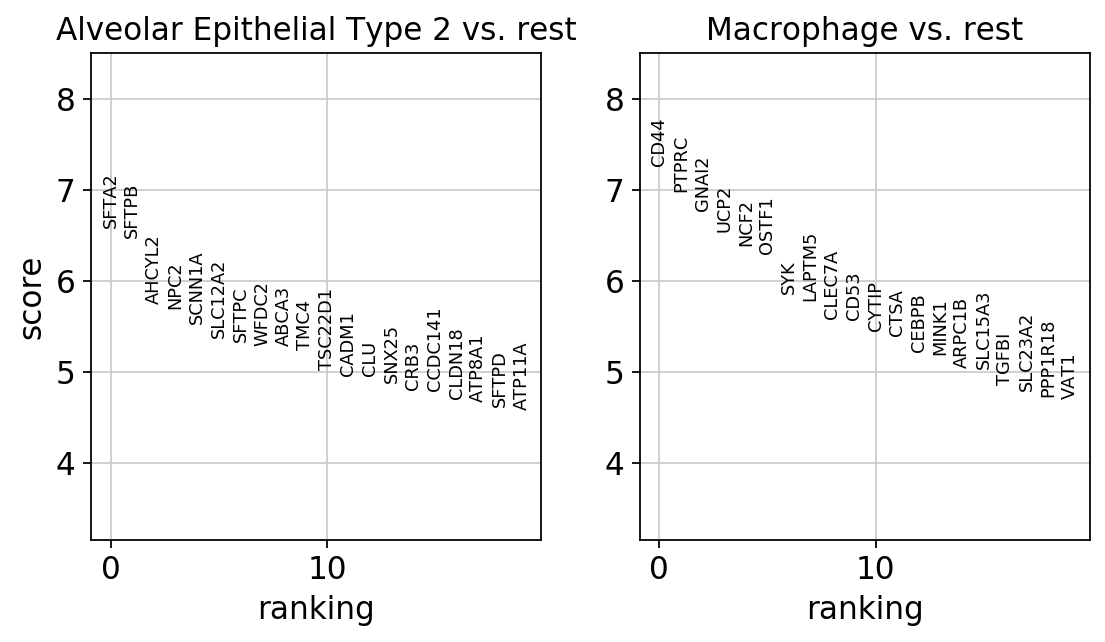

In [47]:
sc.pl.rank_genes_groups(adata_mini)

    using 'X_pca' with n_pcs = 40
Storing dendrogram info using `.uns['dendrogram_narrow_group']`


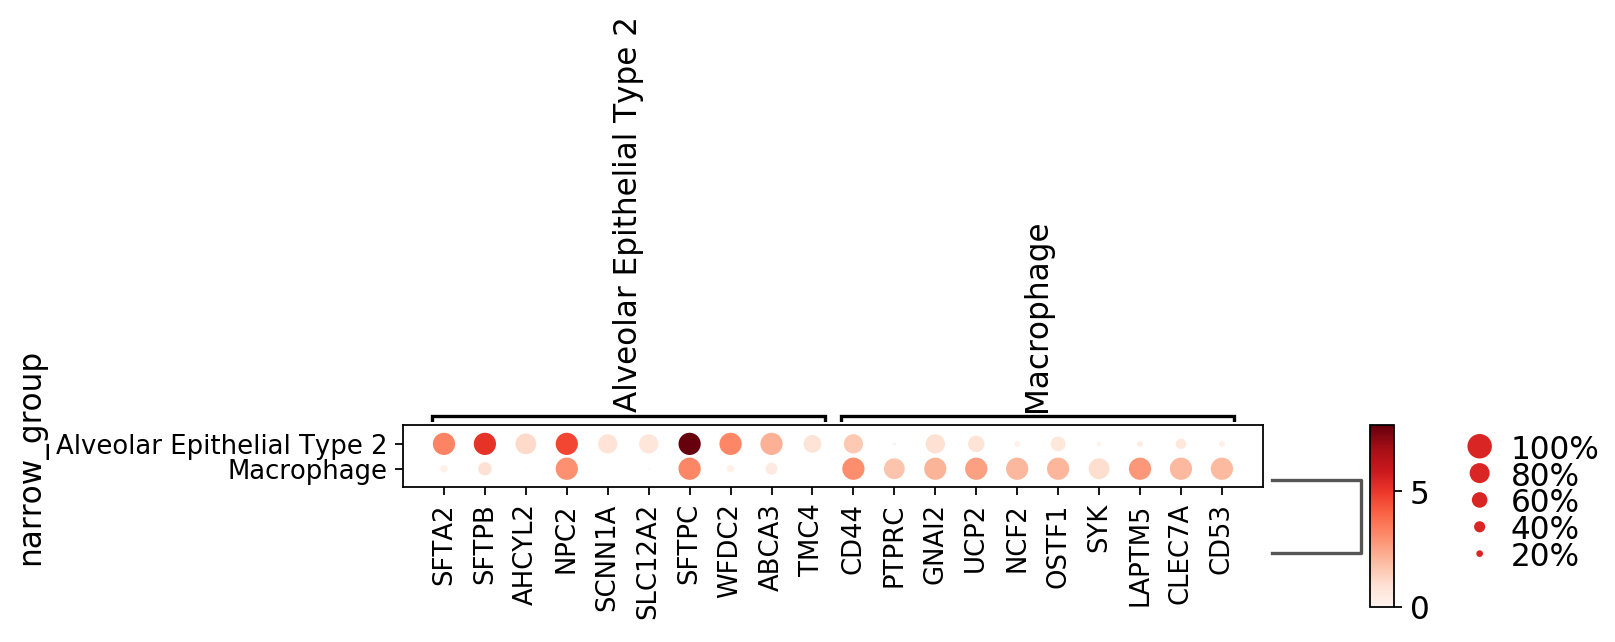

In [48]:
sc.pl.rank_genes_groups_dotplot(adata_mini, log=True)

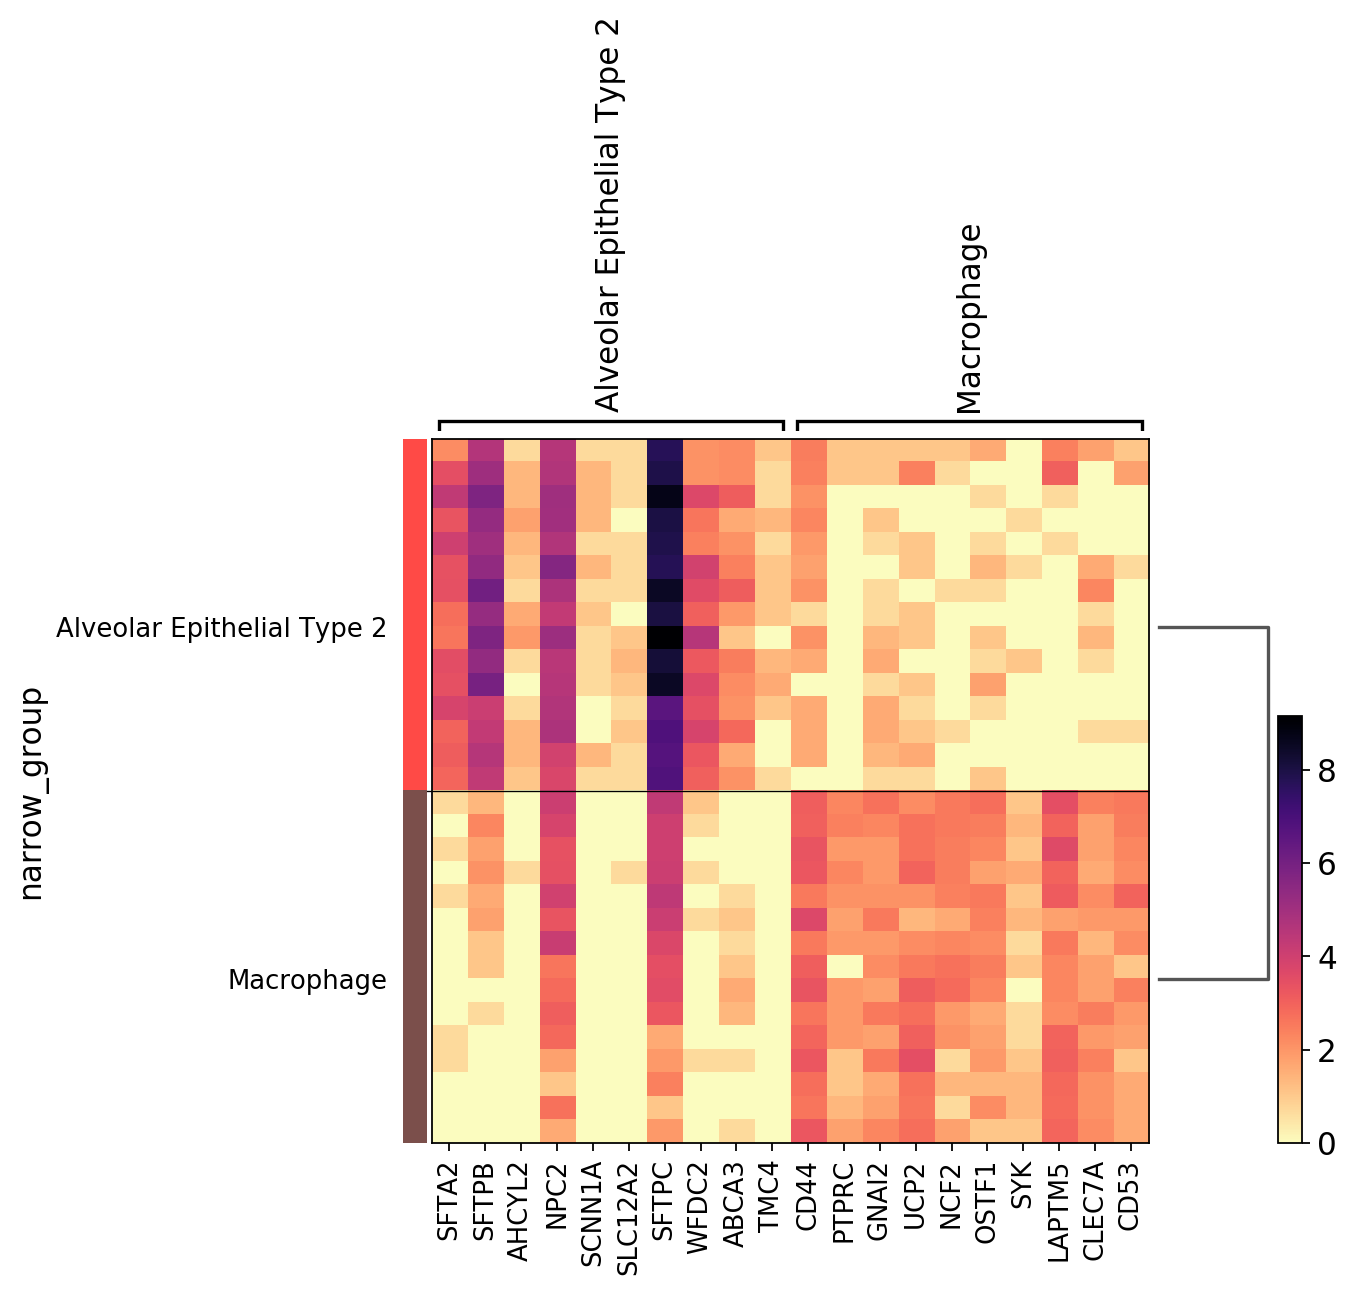

In [49]:
sc.pl.rank_genes_groups_heatmap(adata_mini, log=True)

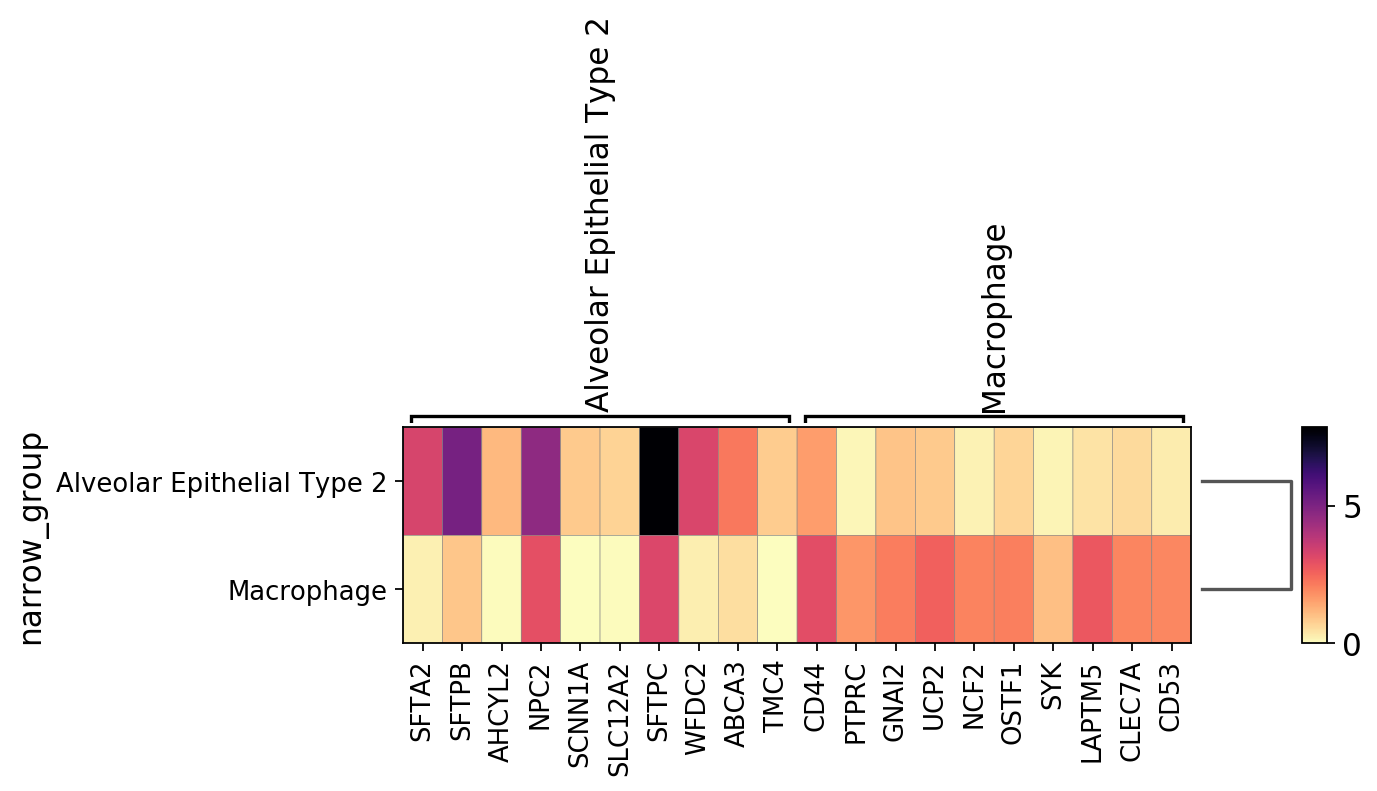

In [50]:
sc.pl.rank_genes_groups_matrixplot(adata_mini, log=True)

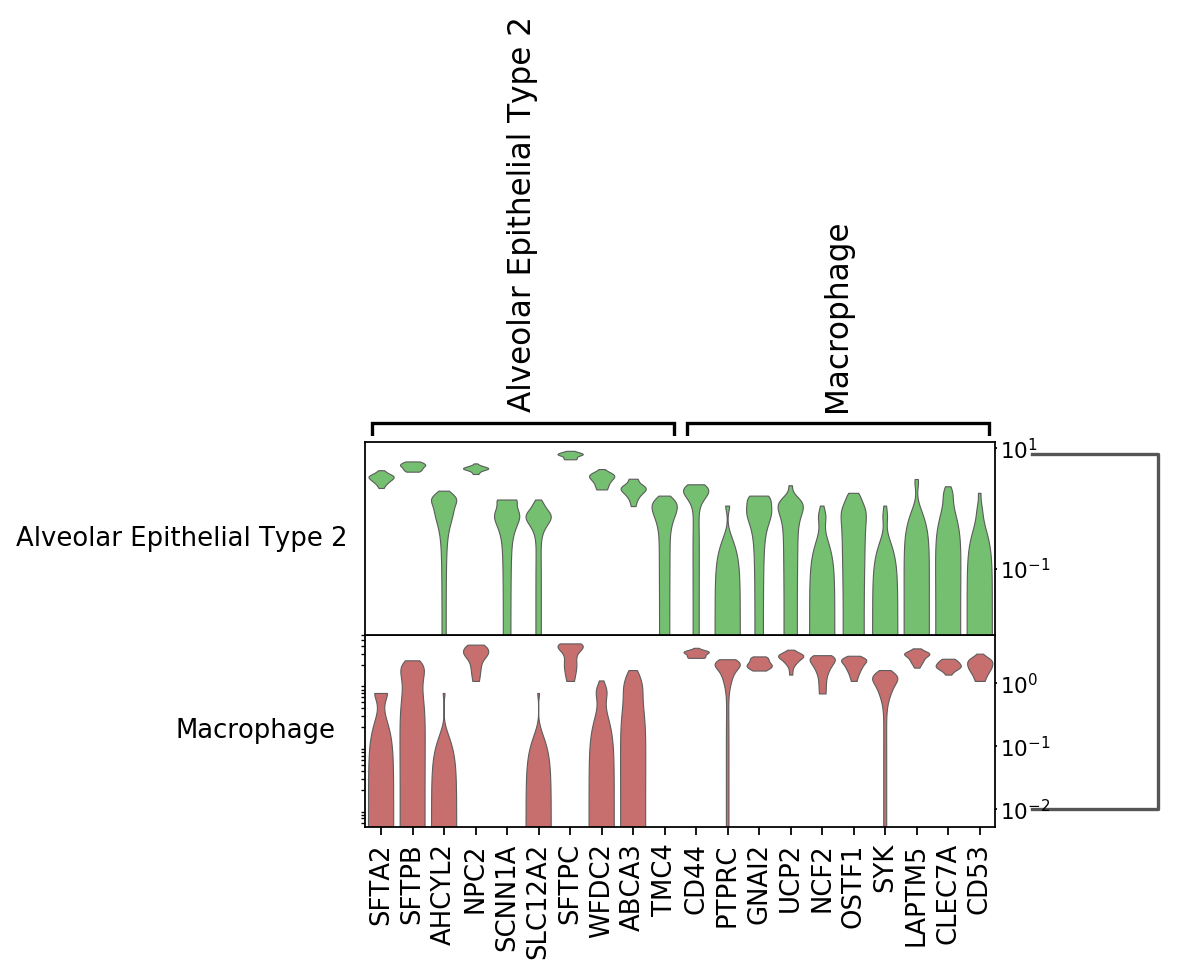

In [51]:
sc.pl.rank_genes_groups_stacked_violin(adata_mini, log=True)

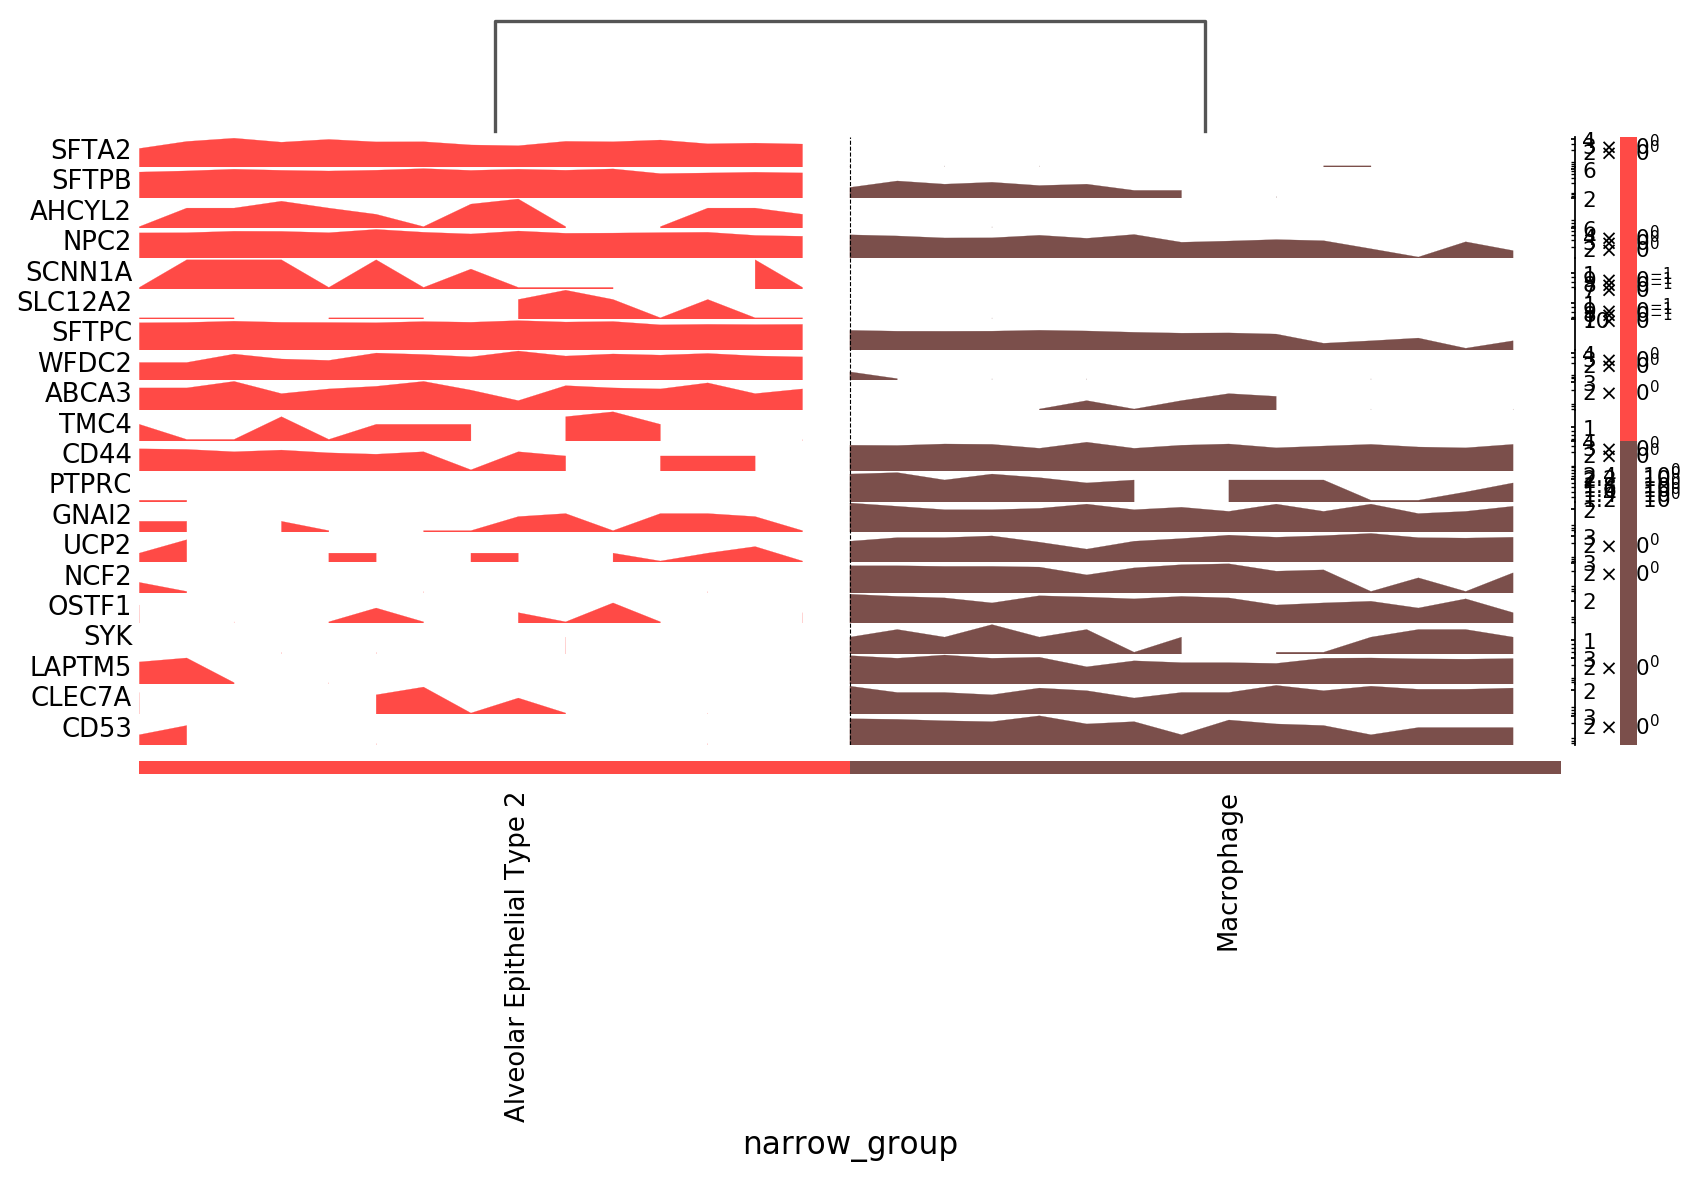

In [52]:
sc.pl.rank_genes_groups_tracksplot(adata_mini, log=True)

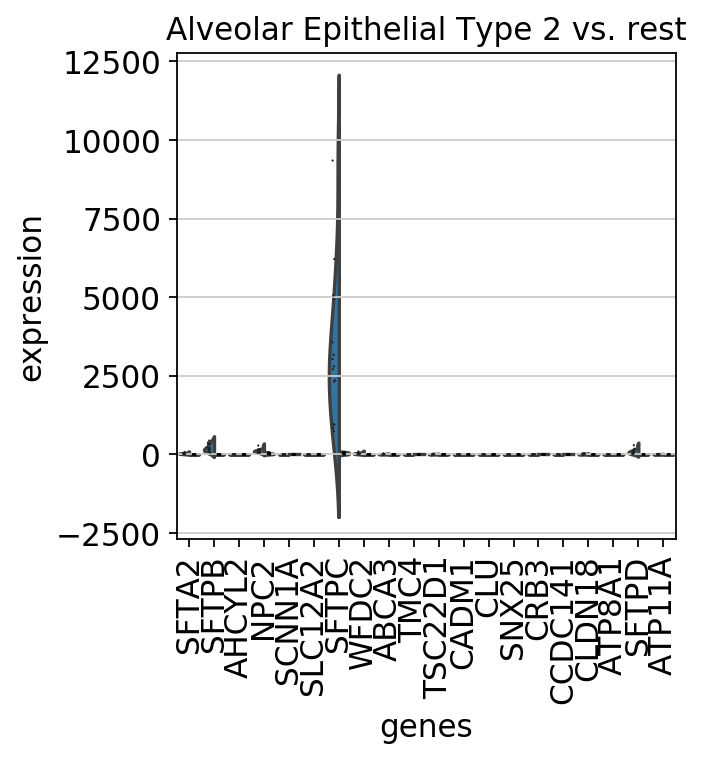

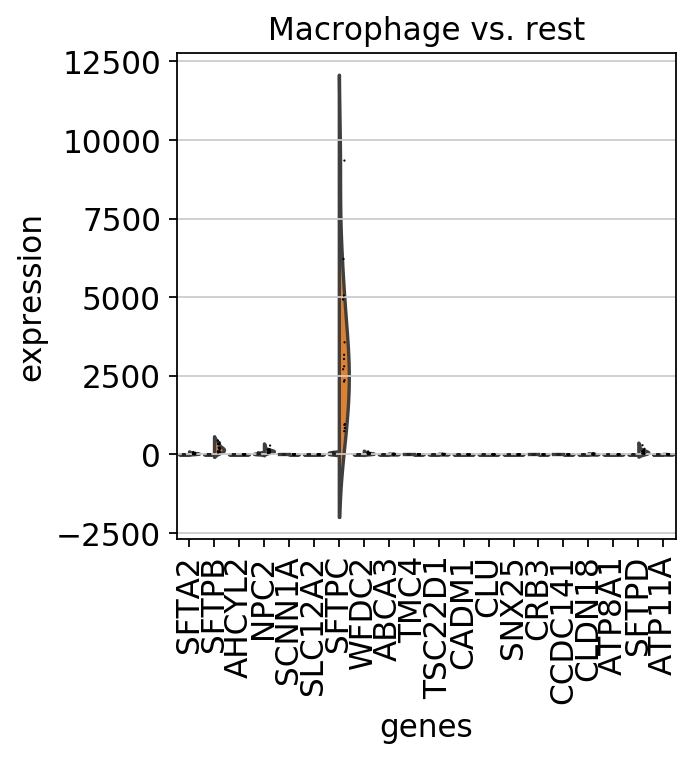

In [53]:
sc.pl.rank_genes_groups_violin(adata_mini)

In [54]:
# adata_mini_de = diffexpr.do_differential_expression(adata_mini, groupby='narrow_group', method='t-test_overestim_var')

In [55]:
# adata_mini_de = diffexpr.do_differential_expression(adata_mini, groupby='narrow_group', solver='liblinear', penalty='l1')

In [56]:
from sklearn.linear_model import LogisticRegression

In [57]:
# X = adata.layers['raw']

In [58]:
type(adata.raw)

NoneType

In [59]:
adata_mini.obs.narrow_group.cat.codes

P1_2_TGCTACCCATTAGCCA-human                      0
P1_2_ACACCGGAGTTACGGG-human                      0
P1_2_CCATGTCAGCTACCTA-human                      0
P1_2_CAGCCGAAGGAGCGTT-human                      0
P1_2_TATGCCCAGGATGGAA-human                      0
Antoine_Lung_EPCAM_10X_CCCAATCGTTGTCGCG-lemur    0
Antoine_Lung_EPCAM_10X_TAAGTGCAGCCCGAAA-lemur    0
Antoine_Lung_EPCAM_10X_TCTCATACATTCCTGC-lemur    0
Antoine_Lung_EPCAM_10X_AGATCTGTCCGCGTTT-lemur    0
Antoine_Lung_EPCAM_10X_TTAACTCGTAAGGGAA-lemur    0
ACCTTTAAGGGCTCTC-1-53-0-0-mouse                  0
CACACAATCCTCAACC-1-53-0-0-mouse                  0
CGGTTAACACCTATCC-1-53-0-0-mouse                  0
GCACTCTCAACGATCT-1-53-0-0-mouse                  0
CTACATTCACCGAATT-1-53-0-0-mouse                  0
P1_2_CACACAAGTCCTAGCG-human                      1
P1_2_TTGCGTCTCCAAGTAC-human                      1
P1_2_ACAGCCGAGCTAGTTC-human                      1
P1_2_AGGTCCGCAGGACGTA-human                      1
P1_2_ACGCCAGGTGTCTGAT-human    

# Get fasta file names

In [60]:
adata_mini.obs.narrow_group

P1_2_TGCTACCCATTAGCCA-human                      Alveolar Epithelial Type 2
P1_2_ACACCGGAGTTACGGG-human                      Alveolar Epithelial Type 2
P1_2_CCATGTCAGCTACCTA-human                      Alveolar Epithelial Type 2
P1_2_CAGCCGAAGGAGCGTT-human                      Alveolar Epithelial Type 2
P1_2_TATGCCCAGGATGGAA-human                      Alveolar Epithelial Type 2
Antoine_Lung_EPCAM_10X_CCCAATCGTTGTCGCG-lemur    Alveolar Epithelial Type 2
Antoine_Lung_EPCAM_10X_TAAGTGCAGCCCGAAA-lemur    Alveolar Epithelial Type 2
Antoine_Lung_EPCAM_10X_TCTCATACATTCCTGC-lemur    Alveolar Epithelial Type 2
Antoine_Lung_EPCAM_10X_AGATCTGTCCGCGTTT-lemur    Alveolar Epithelial Type 2
Antoine_Lung_EPCAM_10X_TTAACTCGTAAGGGAA-lemur    Alveolar Epithelial Type 2
ACCTTTAAGGGCTCTC-1-53-0-0-mouse                  Alveolar Epithelial Type 2
CACACAATCCTCAACC-1-53-0-0-mouse                  Alveolar Epithelial Type 2
CGGTTAACACCTATCC-1-53-0-0-mouse                  Alveolar Epithelial Type 2
GCACTCTCAACG

In [61]:
adata_mini.obs.head()

,age,batch,cell,cell_barcode,cell_ontology_class,cell_ontology_id,channel,channel_no_10x,channel_tissue,compartment,compartment_id,free_annotation,individual,location,magnetic.selection,method,mouse.id,nGene,nUMI,n_barcodes,n_counts,n_genes,orig.ident,original_channel,patient,percent.ribo,possibly_contaminated_barcode,preparation.site,region,sample,sequencing_run,sex,species,species_batch,species_latin,subtissue,tissue,tissue_free_annotation,compartment_updated_from_human,compartment_updated_from_human__with_species,compartment_updated_from_lemur,compartment_updated_from_lemur__with_species,narrow_group,broad_group,compartment_group,log_counts,sqrt_counts
P1_2_TGCTACCCATTAGCCA-human,NaN,NaN,NaN,TGCTACCCATTAGCCA,type II pneumocyte,NaN,P1_2,NaN,NaN,epithelial,NaN,Alveolar Epithelial Type 2,NaN,distal,epithelial,NaN,NaN,4931.0,32187.0,NaN,3299,3299,Human Lung 10x - Patient 1,NaN,1.0,0.121198,NaN,biohub,normal,distal 1a,171205_A00111_0088_BH55NYDMXX,NaN,Human,human,Homo sapiens,NaN,Lung,NaN,epithelial,epithelial (Human),epithelial,epithelial (Human),Alveolar Epithelial Type 2,Alveolar Epithelial Type 2,epithelial,9.668588,125.749748
P1_2_ACACCGGAGTTACGGG-human,NaN,NaN,NaN,ACACCGGAGTTACGGG,type II pneumocyte,NaN,P1_2,NaN,NaN,epithelial,NaN,Alveolar Epithelial Type 2,NaN,distal,epithelial,NaN,NaN,4510.0,28732.0,NaN,3030,3030,Human Lung 10x - Patient 1,NaN,1.0,0.125331,NaN,biohub,normal,distal 1a,171205_A00111_0088_BH55NYDMXX,NaN,Human,human,Homo sapiens,NaN,Lung,NaN,epithelial,epithelial (Human),epithelial,epithelial (Human),Alveolar Epithelial Type 2,Alveolar Epithelial Type 2,epithelial,9.614071,122.368294
P1_2_CCATGTCAGCTACCTA-human,NaN,NaN,NaN,CCATGTCAGCTACCTA,type II pneumocyte,NaN,P1_2,NaN,NaN,epithelial,NaN,Alveolar Epithelial Type 2,NaN,distal,epithelial,NaN,NaN,4490.0,31702.0,NaN,3014,3014,Human Lung 10x - Patient 1,NaN,1.0,0.156457,NaN,biohub,normal,distal 1a,171205_A00111_0088_BH55NYDMXX,NaN,Human,human,Homo sapiens,NaN,Lung,NaN,epithelial,epithelial (Human),epithelial,epithelial (Human),Alveolar Epithelial Type 2,Alveolar Epithelial Type 2,epithelial,9.865422,138.755173
P1_2_CAGCCGAAGGAGCGTT-human,NaN,NaN,NaN,CAGCCGAAGGAGCGTT,type II pneumocyte,NaN,P1_2,NaN,NaN,epithelial,NaN,Alveolar Epithelial Type 2,NaN,distal,epithelial,NaN,NaN,4333.0,28696.0,NaN,2965,2965,Human Lung 10x - Patient 1,NaN,1.0,0.198146,NaN,biohub,normal,distal 1a,171205_A00111_0088_BH55NYDMXX,NaN,Human,human,Homo sapiens,NaN,Lung,NaN,epithelial,epithelial (Human),epithelial,epithelial (Human),Alveolar Epithelial Type 2,Alveolar Epithelial Type 2,epithelial,9.720886,129.081375
P1_2_TATGCCCAGGATGGAA-human,NaN,NaN,NaN,TATGCCCAGGATGGAA,type II pneumocyte,NaN,P1_2,NaN,NaN,epithelial,NaN,Alveolar Epithelial Type 2,NaN,distal,epithelial,NaN,NaN,4147.0,19244.0,NaN,2765,2765,Human Lung 10x - Patient 1,NaN,1.0,0.151736,NaN,biohub,normal,distal 1a,171205_A00111_0088_BH55NYDMXX,NaN,Human,human,Homo sapiens,NaN,Lung,NaN,epithelial,epithelial (Human),epithelial,epithelial (Human),Alveolar Epithelial Type 2,Alveolar Epithelial Type 2,epithelial,9.359708,107.754349


In [62]:
adata_mini.obs['cell_barcode'].nunique()

30

In [63]:
adata_mini.obs.loc[adata_mini.obs.cell_barcode.isnull()]

,age,batch,cell,cell_barcode,cell_ontology_class,cell_ontology_id,channel,channel_no_10x,channel_tissue,compartment,compartment_id,free_annotation,individual,location,magnetic.selection,method,mouse.id,nGene,nUMI,n_barcodes,n_counts,n_genes,orig.ident,original_channel,patient,percent.ribo,possibly_contaminated_barcode,preparation.site,region,sample,sequencing_run,sex,species,species_batch,species_latin,subtissue,tissue,tissue_free_annotation,compartment_updated_from_human,compartment_updated_from_human__with_species,compartment_updated_from_lemur,compartment_updated_from_lemur__with_species,narrow_group,broad_group,compartment_group,log_counts,sqrt_counts


In [64]:
adata_mini.obs['channel'].value_counts()

P1_2                      10
MACA_21m_F_LUNG_55        10
Antoine_Lung_EPCAM_10X    10
Name: channel, dtype: int64

In [65]:
adata_mini.obs['channel_no_10x'].value_counts()

ANTOINE_LUNG_EPCAM    10
Name: channel_no_10x, dtype: int64

In [66]:
channel_mapper = {'P1_2': 'HUMAN_HCA_LUNG_LUNG_CD45_OR_CD31', 
                  'MACA_21m_F_LUNG_55': 'MACA_21m_F_LUNG_55',
                  'Antoine_Lung_EPCAM_10X': 'ANTOINE_LUNG_EPCAM_POS'
                 }

adata_mini.obs['channel_original'] = adata_mini.obs.channel.map(channel_mapper)
adata_mini.obs['channel_original'].value_counts()

HUMAN_HCA_LUNG_LUNG_CD45_OR_CD31    10
MACA_21m_F_LUNG_55                  10
ANTOINE_LUNG_EPCAM_POS              10
Name: channel_original, dtype: int64

In [69]:
peptides_cols = ['peptides_aligned', 'peptides_unaligned']

adata_mini.obs['peptides_aligned'] = adata_mini.obs.apply(lambda x: '{channel_original}__aligned__{cell_barcode}__coding_reads_peptides.fasta'.format(**x), axis=1)
adata_mini.obs['peptides_unaligned'] = adata_mini.obs.apply(lambda x: '{channel_original}__unaligned__{cell_barcode}__coding_reads_peptides.fasta'.format(**x), axis=1)
adata_mini.obs[peptides_cols].sample(5).values

array([['ANTOINE_LUNG_EPCAM_POS__aligned__TCTCATACATTCCTGC__coding_reads_peptides.fasta',
        'ANTOINE_LUNG_EPCAM_POS__unaligned__TCTCATACATTCCTGC__coding_reads_peptides.fasta'],
       ['ANTOINE_LUNG_EPCAM_POS__aligned__CGTTGGGAGGGTTCCC__coding_reads_peptides.fasta',
        'ANTOINE_LUNG_EPCAM_POS__unaligned__CGTTGGGAGGGTTCCC__coding_reads_peptides.fasta'],
       ['HUMAN_HCA_LUNG_LUNG_CD45_OR_CD31__aligned__CAGCCGAAGGAGCGTT__coding_reads_peptides.fasta',
        'HUMAN_HCA_LUNG_LUNG_CD45_OR_CD31__unaligned__CAGCCGAAGGAGCGTT__coding_reads_peptides.fasta'],
       ['ANTOINE_LUNG_EPCAM_POS__aligned__CATCCACAGCTCCTCT__coding_reads_peptides.fasta',
        'ANTOINE_LUNG_EPCAM_POS__unaligned__CATCCACAGCTCCTCT__coding_reads_peptides.fasta'],
       ['MACA_21m_F_LUNG_55__aligned__ACCTTTAAGGGCTCTC__coding_reads_peptides.fasta',
        'MACA_21m_F_LUNG_55__unaligned__ACCTTTAAGGGCTCTC__coding_reads_peptides.fasta']],
      dtype=object)

## Write mini adata to file - with aligned, unaligned names

In [94]:
mini_prefix = 'mini_adata_30cells_xspecies_at2_macrophage'

for d in outdirs:
    adata_mini.write(f'{d}/{mini_prefix}.h5ad')

# Check if thses samples ahve already been translated

In [71]:
translate_dir = '/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/mini-test-at2-vs-macrophages/remove_ribo_ksize_mammals/translate'
 

In [72]:

for col in peptides_cols:
    adata_mini.obs[f'{col}_exists'] = adata_mini.obs[col].map(lambda x: os.path.exists(f'{translate_dir}/{x}'))
    print(f"adata_mini.obs[f'{col}_exists']: ", adata_mini.obs[f'{col}_exists'].sum())

adata_mini.obs[f'peptides_aligned_exists']:  0
adata_mini.obs[f'peptides_unaligned_exists']:  0


In [150]:
# import glob

# for i, filename in zip(range(5), glob.iglob(f'{translate_dir}/*peptides.fasta')):
#     print(filename)

/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/mini-test-at2-vs-macrophages/remove_ribo_ksize_mammals/translate/MACA_21m_F_LUNG_55__unaligned__TCAGCTCTCTTGACGA__coding_reads_peptides.fasta
/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/mini-test-at2-vs-macrophages/remove_ribo_ksize_mammals/translate/HUMAN_HCA_LUNG_LUNG_CD45_OR_CD31__unaligned__CCCTCCTGTAAACGCG__coding_reads_peptides.fasta
/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/mini-test-at2-vs-macrophages/remove_ribo_ksize_mammals/translate/ANTOINE_LUNG_EPCAM_POS__unaligned__CTCTGGTCAGCCTTTC__coding_reads_peptides.fasta
/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/mini-test-at2-vs-macrophages/remove_ribo_ksize_mammals/translate/ANTOINE_LUNG_EPCAM_POS__unaligned__CTCGTCACATCAGTCA__coding_reads_peptides.fasta
/mnt/data_lg/data_sm_copy/olga/tabula-microcebus/analyses/kmermaid/mini-test-at2-vs-macrophages/remove_ribo_ksize_mammals/translate/HUMAN_HCA_

# Do logistic regression

## REmove genes that are zero for both groups

In [162]:
# some_nonzero = np.any(adata.X > 0, axis=1)
# print(some_nonzero.sum())
# print(len(some_nonzero))
# some_nonzero

In [163]:
X = adata_mini.X[:, ]

## Actually do the logistic regression

In [98]:
penalties = 'l1', 'l2'

macrophage_target = adata_mini.obs.narrow_group.cat.codes
at2_target = ~adata_mini.obs.narrow_group.cat.codes

targets = {'macrophage': macrophage_target, 'at2': at2_target}

for name, target in targets.items():
    print(f'name: {name}')
    for penalty in penalties:
        print(f'\tpenalty: {penalty}')
        clf = LogisticRegression(solver='liblinear', penalty=penalty)
        clf.fit(adata_mini.X, target)
        scores = pd.Series(clf.coef_.flatten(), index=adata_mini.var.index)
        scores.name = name
        print(scores.shape)
        print('Number of nonzeros:', (scores > 0).sum())
        print(scores.nlargest(5))
        for d in outdirs:
            scores.to_csv(f"{d}/{mini_prefix}__logisticregression__penalty-{penalty}__scores-{name}.csv", 
                          index=True, header=True)

name: macrophage
	penalty: l1
(11761,)
Number of nonzeros: 4
ACTB      0.065922
B2M       0.025600
PSAP      0.010607
CD9       0.003397
SAMD11    0.000000
Name: macrophage, dtype: float64
	penalty: l2
(11761,)
Number of nonzeros: 7462
ACTB      0.016510
B2M       0.009744
RPL37A    0.007991
PSAP      0.007793
CD9       0.007323
Name: macrophage, dtype: float64
name: at2
	penalty: l1
(11761,)
Number of nonzeros: 1
SFTPC     0.01052
SAMD11    0.00000
NOC2L     0.00000
KLHL17    0.00000
ISG15     0.00000
Name: at2, dtype: float64
	penalty: l2
(11761,)
Number of nonzeros: 1273
SFTPC      0.016551
SFTPB      0.001778
SLC34A2    0.001220
SFTA2      0.000841
SFTPD      0.000764
Name: at2, dtype: float64


In [88]:
clf2 = LogisticRegression(solver='liblinear', penalty=penalty)
clf2.fit(adata_mini.X, )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [89]:
scores_macrophage = pd.Series(clf.coef_.flatten(), index=adata_mini.var.index)
print(scores_macrophage.shape)
scores_macrophage.nlargest(10)

(11761,)


ACTB        0.070288
B2M         0.021008
CD9         0.009196
SAMD11      0.000000
NOC2L       0.000000
KLHL17      0.000000
ISG15       0.000000
AGRN        0.000000
C1orf159    0.000000
TTLL10      0.000000
dtype: float64

In [90]:
(scores_macrophage > 0).sum()

3

In [91]:
scores_macrophage['PTPRC']

0.0

In [92]:
scores_at2 = pd.Series(clf2.coef_.flatten(), index=adata_mini.var.index)
print(scores_at2.shape)
scores_at2.nlargest(10)

(11761,)


SFTPC       0.010578
SAMD11      0.000000
NOC2L       0.000000
KLHL17      0.000000
ISG15       0.000000
AGRN        0.000000
C1orf159    0.000000
TTLL10      0.000000
TNFRSF18    0.000000
TNFRSF4     0.000000
dtype: float64

In [87]:
(scores_at2 > 0).sum()

1273